# RNN Basic - 학습용 sequence length 의 영향

## 학습 데이터 mini-batch 구성의 차이 FCN, 2D-CNN vs RNN

- FCN ( Fully Connected Network, a.k.a. `dense` )

  - `[batch, inputs]`
  - e.g.: [`tf.layers.dense()`](http://devdocs.io/tensorflow~python/tf/layers/dense)


- 2D-CNN 의 경우 학습데이터 feed 구성

  - `[batch, height, width, channel]` : `data_format = "NHWC"` (default)
  - `[batch, channel, height, width]` : `data_format = "NCHW"`
  - e.g.: [`tf.layers.conv2d()`](http://devdocs.io/tensorflow~python/tf/layers/conv2d)



- RNN 의 경우 학습 데이터 feed 구성

  - `[batch, sequence, input]` : `time_major = False` (default for [`tf.nn.dynamic_rnn()`](http://devdocs.io/tensorflow~python/tf/nn/dynamic_rnn))
  - `[sequence, batch, input]` : `time_major = True`  (default for [`tf.nn.static_rnn()`](http://devdocs.io/tensorflow~python/tf/nn/static_rnn))



In [1]:
%load_ext do_not_print_href
%matplotlib inline
from __future__ import print_function, division
import sys
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# !rm -fr logdir
# !mkdir -p logdir

## 데이터 준비

- 1주차 실습에 사용한 것과 동일한 데이터
- 5주차 실습에서는 tensorflow example 의 기본 제공 메소드를 이용

In [3]:
from tensorflow.examples.tutorials.mnist.input_data \
    import read_data_sets

In [4]:
mnist = read_data_sets('./mnist', one_hot=False)
mnist

Extracting ./mnist/train-images-idx3-ubyte.gz
Extracting ./mnist/train-labels-idx1-ubyte.gz
Extracting ./mnist/t10k-images-idx3-ubyte.gz
Extracting ./mnist/t10k-labels-idx1-ubyte.gz


Datasets(train=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x7fa365222e50>, validation=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x7fa317389d90>, test=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x7fa317389910>)

## 이미지 하나만 골라서 확인

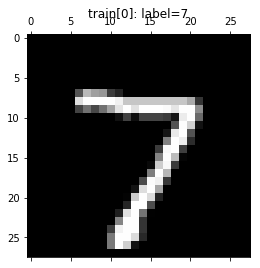

In [5]:
i = 0
img = mnist.test.images[i,:].reshape([28,28])
lbl = mnist.test.labels[i]
plt.matshow(img,cmap=plt.get_cmap('gray'))
plt.title('train[{:d}]: label={:d}'.format(i,lbl))
plt.show()

## RNN 학습 입력으로 사용하기 위해서 입력값의 해석 방식을 달리함

- 28 x 28 = 784 개 입력값을

- 28개 입력값의 길이 <span style="color:red">s ( s <= 28 )</span> 인 시퀀스로 해석


## 참고: sequence length 제한 이전의 RNN 구조

<img  src="Selection_20170912_110940_c175.png"/>

## 학습 데이터의 규격 설정

In [6]:
INPUT_UNITS = 28
NUM_HIDDEN_UNITS = 31

BATCH_SIZE = 128
MAX_SEQ_LEN = 19  # <<=== s <= 28

## RNN 모델 구성

In [7]:
class MnistRnn:
    def __init__(self, 
                 inputs, 
                 labels, 
                 input_units, 
                 num_hidden_units, 
                 batch_size, 
                 max_seq_len):
        '''
        inputs: in shape [batch_size, max_seq_len, input_size]
        labels: in shape [batch_size]
        '''

        # ===>>> MultiRNNCell <<<===
        multi_cells     = tf.contrib.rnn.MultiRNNCell([
                            tf.contrib.rnn.BasicRNNCell(
                                num_hidden_units) \
                            for _ in \
                            range(3) ])

        sequence_length = [max_seq_len] * batch_size
        last, states    = tf.nn.dynamic_rnn(
                            multi_cells, 
                            inputs, 
                            sequence_length=sequence_length, 
                            dtype=tf.float32)
        
        # 여기서,
        # last.shape: [batch_size, max_seq_len, num_hidden_units]
        
        #####################################################
        # MultiRNNCell 을 쓰면 states값이 tensor 의 tuple 이 됨.
        # states.shape : ([?, num_hidden_units],...)
        #####################################################

        print('last.shape', last.get_shape().as_list())
        print('states', states)

        # max_seq_len 축으로 0~27 까지 값 중에 
        # 0~26 때의 출력 값은 사용하지 않음
        rnn_output = last[:,max_seq_len-1,:] 
        # rnn_output shape: [batch_size, num_hidden_units]
        print('rnn_output.shape', rnn_output.get_shape().as_list())

        # 10 개의 output units 로 만들 
        # FCN (fully-connected-network) 구성
        # ==> shape: [batch_size, 10]
        outputs    = tf.layers.dense(rnn_output, 10)
        print('outputs.shape', outputs.get_shape().as_list())

        # loss 함수
        loss       = tf.losses.sparse_softmax_cross_entropy(
                        labels, outputs)
        optimize   = tf.train.AdamOptimizer(learning_rate=0.001). \
                        minimize(loss)

        # accuracy
        preds    = tf.argmax(outputs, axis=1)
        errors   = tf.count_nonzero(labels - preds)
        accuracy = 1.0 - tf.cast(errors,tf.float32) / \
                         tf.cast(tf.size(preds),tf.float32)

        # 클래스 객체 외부에서 참고할 수 있도록 속성으로 저장
        self.outputs        = outputs
        self.loss           = loss
        self.optimize       = optimize
        self.accuracy       = accuracy

## 텐서플로우 그래프 초기화, Placeholders 정의, 그래프 빌드

In [8]:
tf.reset_default_graph()

inputs_ = tf.placeholder(
            tf.float32,
            [BATCH_SIZE, MAX_SEQ_LEN, INPUT_UNITS],
            name='inputs')
labels_ = tf.placeholder(
            tf.int64,
            [BATCH_SIZE],
            name='labels')

model = MnistRnn(inputs_,
                 labels_,
                 INPUT_UNITS,
                 NUM_HIDDEN_UNITS,
                 BATCH_SIZE,
                 MAX_SEQ_LEN)

last.shape [128, 19, 31]
states (<tf.Tensor 'rnn/while/Exit_2:0' shape=(128, 31) dtype=float32>, <tf.Tensor 'rnn/while/Exit_3:0' shape=(128, 31) dtype=float32>, <tf.Tensor 'rnn/while/Exit_4:0' shape=(128, 31) dtype=float32>)
rnn_output.shape [128, 31]
outputs.shape [128, 10]


## 학습을 위한 세션 초기화, 변수 초기화

In [9]:
config = tf.ConfigProto(gpu_options={'allow_growth':True})
sess = tf.InteractiveSession(config=config)

tf.global_variables_initializer().run()

## 훈련 진도 기록용 summary writer 

In [10]:
train_writer = tf.summary.FileWriter(
    'logdir/train3',
    graph=tf.get_default_graph())
test_writer  = tf.summary.FileWriter(
    'logdir/test3',
    graph=tf.get_default_graph())

## 훈련용 데이터 시퀀스 준비

- MAX_SEQ_LEN == 28 일때


```
        offs        = i * BATCH_SIZE
        batch_input = \
            mnist.train.images[offs:offs+BATCH_SIZE,:]
        batch_input = \
            batch_input.reshape([BATCH_SIZE,
                                    MAX_SEQ_LEN,
                                    INPUT_UNITS])
        batch_label = \
            mnist.train.labels[offs:offs+BATCH_SIZE]
```

- MAX_SEQ_LEN != 28 일때


<code>
        offs        = np.random.randint(
            mnist.train.num_examples // BATCH_SIZE) *
            BATCH_SIZE
        batch_input = \
            mnist.train.images[offs:offs+BATCH_SIZE,:]
        batch_input = \
            batch_input.reshape([BATCH_SIZE,
                                    28, # MAX_SEQ_LEN,
                                    INPUT_UNITS])
        batch_collection = []
        for ii in xrange(BATCH_SIZE):
            seq_start = np.random.randint(28 - MAX_SEQ_LEN + 1)
            batch_collection.append(
                batch_input[
                    ii,
                    seq_start:seq_start+MAX_SEQ_LEN,
                    :])
        batch_input = np.array(batch_collection)
        batch_label = \
            mnist.train.labels[offs:offs+BATCH_SIZE]
</code>

## 훈련 루프 카운트 계산

In [11]:
train_loop_count = mnist.train.num_examples * \
        (28 - MAX_SEQ_LEN + 1) // \
        BATCH_SIZE
test_loop_count  = mnist.test.num_examples * \
        (28 - MAX_SEQ_LEN + 1) // \
        BATCH_SIZE

train_loop_count, test_loop_count

(4296, 781)

## 훈련 루프 정의

In [12]:
def train(
    inputs,
    labels,
    max_epochs,
    train_writer=None,
    test_writer=None):
    
    step = 0
    for ep in range(max_epochs):

        train_elapsed = []
        train_losses = []
        train_accuracy = []
        for i in range(train_loop_count):
            t_start     = time.time()

            offs        = np.random.randint(
                mnist.train.num_examples // BATCH_SIZE) * \
                BATCH_SIZE
            batch_input = \
                mnist.train.images[offs:offs+BATCH_SIZE,:]
            batch_input = \
                batch_input.reshape([BATCH_SIZE,
                                        28, # MAX_SEQ_LEN,
                                        INPUT_UNITS])
            batch_collection = []
            for ii in xrange(BATCH_SIZE):
                seq_start = np.random.randint(28 - MAX_SEQ_LEN + 1)
                batch_collection.append(
                    batch_input[
                        ii,
                        seq_start:seq_start+MAX_SEQ_LEN,
                        :])
            batch_input = np.array(batch_collection)
            batch_label = \
                mnist.train.labels[offs:offs+BATCH_SIZE]            
            
            optimize, loss, accuracy, = \
                sess.run([model.optimize,
                          model.loss,
                          model.accuracy],
                         feed_dict = {
                          inputs: batch_input,
                          labels: batch_label })
            train_losses.append(loss)
            train_accuracy.append(accuracy)
            t_elapsed   = time.time() - t_start
            train_elapsed.append(t_elapsed)

            step += 1

            if train_writer:
                summary = tf.Summary(
                    value=[
                        tf.Summary.Value(
                            tag='train_accuracy',
                            simple_value=accuracy
                        ),
                        tf.Summary.Value(
                            tag='loss',
                            simple_value=loss
                        ),
                    ]
                )
                train_writer.add_summary(summary,global_step=step)

            if step % 500 == 0:
                print(('[trn] ep {:d}, step {:d}, ' + 
                       'loss {:f}, accu {:f}, ' + 
                       'sec/iter {:f}').format(
                    ep + 1,
                    step,
                    np.mean(train_losses),
                    np.amin(train_accuracy),
                    np.mean(train_elapsed)))
                train_losses = []
                train_accuracy = []
                train_elapsed = []

        test_elapsed  = []
        test_accuracy = []
        for i in range(test_loop_count):
            t_start     = time.time()

            offs        = np.random.randint(
                mnist.test.num_examples // BATCH_SIZE) * \
                BATCH_SIZE

            batch_input = \
                mnist.test.images[offs:offs+BATCH_SIZE,:]
            batch_input = \
                batch_input.reshape([BATCH_SIZE,
                                        28, # MAX_SEQ_LEN,
                                        INPUT_UNITS])
            batch_collection = []
            for ii in xrange(BATCH_SIZE):
                seq_start = np.random.randint(28 - MAX_SEQ_LEN + 1)
                batch_collection.append(
                    batch_input[
                        ii,
                        seq_start:seq_start+MAX_SEQ_LEN,
                        :])
            batch_input = np.array(batch_collection)
            batch_label = \
                mnist.test.labels[offs:offs+BATCH_SIZE]            

            accuracy, = \
                sess.run([model.accuracy],
                         feed_dict = {
                          inputs: batch_input,
                          labels: batch_label })
            test_accuracy.append(accuracy)
            t_elapsed   = time.time() - t_start
            test_elapsed.append(t_elapsed)

            step += 1
            
            if test_writer:
                summary = tf.Summary(
                    value=[
                        tf.Summary.Value(
                            tag='test_accuracy',
                            simple_value=accuracy
                        ),
                    ]
                )
                test_writer.add_summary(summary,global_step=step)

            if step % 500 == 0:
                print(('[tst] ep {:d}, ' +
                       'step {:d}, accu {:f}, ' + 
                       'sec/iter {:f}').format(
                    ep + 1,
                    step,
                    np.amin(test_accuracy),
                    np.mean(test_elapsed)))
                test_accuracy = []
                test_elapsed  = []


## 훈련 루프 실행

In [13]:
tf.get_default_graph().finalize()
train(inputs_, labels_, 2, train_writer, test_writer)

[trn] ep 1, step 500, loss 1.409534, accu 0.093750, sec/iter 0.009095
[trn] ep 1, step 1000, loss 0.842891, accu 0.554688, sec/iter 0.008731
[trn] ep 1, step 1500, loss 0.611520, accu 0.656250, sec/iter 0.008772
[trn] ep 1, step 2000, loss 0.489022, accu 0.695312, sec/iter 0.008870
[trn] ep 1, step 2500, loss 0.407674, accu 0.757812, sec/iter 0.008725
[trn] ep 1, step 3000, loss 0.361474, accu 0.781250, sec/iter 0.009582
[trn] ep 1, step 3500, loss 0.333060, accu 0.765625, sec/iter 0.009126
[trn] ep 1, step 4000, loss 0.300694, accu 0.789062, sec/iter 0.008858
[tst] ep 1, step 4500, accu 0.789062, sec/iter 0.003388
[tst] ep 1, step 5000, accu 0.789062, sec/iter 0.003339
[trn] ep 2, step 5500, loss 0.279479, accu 0.796875, sec/iter 0.008812
[trn] ep 2, step 6000, loss 0.262950, accu 0.820312, sec/iter 0.008824
[trn] ep 2, step 6500, loss 0.257611, accu 0.828125, sec/iter 0.009544
[trn] ep 2, step 7000, loss 0.249612, accu 0.828125, sec/iter 0.009519
[trn] ep 2, step 7500, loss 0.239785,

## 훈련 진행 점검 - 텐서보드

In [14]:
# !tensorboard --ip 0.0.0.0 --logdir logdir